### Inciso 1 – Binarización de la variable objetivo

La limpieza de datos ya se había realizado en el proyecto previo.
En este inciso únicamente se transformó la variable **Addiction_Level** en binaria, usando la mediana como umbral:

- **0** = nivel bajo de adicción (≤ mediana)
- **1** = nivel alto de adicción (> mediana)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

df = pd.read_csv("teen_phone_addiction_dataset.csv")
df = df.drop(columns=["Name","Location","School_Grade"], errors="ignore")
df_encoded = pd.get_dummies(df, drop_first=True)

Q1 = df_encoded["Addiction_Level"].quantile(0.25)
Q3 = df_encoded["Addiction_Level"].quantile(0.75)
IQR = Q3 - Q1
mask = (df_encoded["Addiction_Level"] < Q1 - 1.5*IQR) | (df_encoded["Addiction_Level"] > Q3 + 1.5*IQR)
df_no_outliers = df_encoded.loc[~mask].copy()

df_imputed = df_no_outliers.fillna(df_no_outliers.mean(numeric_only=True))

X_tmp = df_imputed.drop(columns=["Addiction_Level","ID"], errors="ignore")
y_cont = df_imputed["Addiction_Level"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tmp)
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y_cont)
selected = X_tmp.columns[(lasso.coef_ != 0)].tolist()

threshold = df_imputed["Addiction_Level"].median()
y_binary = np.where(df_imputed["Addiction_Level"] > threshold, 1, 0)

### Inciso 2 – División en entrenamiento y prueba

Se realizó la división de los datos en **80% entrenamiento** y **20% prueba** mediante muestreo estratificado, asegurando que las proporciones de las clases se mantuvieran prácticamente iguales en ambos subconjuntos. Esto garantiza que el modelo se entrene y evalúe con un balance representativo de las dos clases.

In [6]:
y_binary = pd.qcut(
    df_imputed["Addiction_Level"].rank(method="first"),
    q=[0, 0.5, 1.0],
    labels=[0, 1]
).astype(int)

X = df_imputed[selected].copy()
y = pd.Series(y_binary, name="target")

def proporciones(yvec, titulo):
    p = yvec.value_counts(normalize=True).sort_index().reindex([0,1], fill_value=0.0)
    print(f"{titulo} -> 0:{p.loc[0]:.3f} | 1:{p.loc[1]:.3f} (n={len(yvec)})")

proporciones(y, "Datos originales")

from sklearn.model_selection import StratifiedShuffleSplit

def split_con_dos_clases(X, y, test_size=0.20, intentos=30, seed=42):
    sss = StratifiedShuffleSplit(n_splits=intentos, test_size=test_size, random_state=seed)
    for tr_idx, te_idx in sss.split(X, y):
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        if y_tr.nunique() == 2 and y_te.nunique() == 2:
            return X.iloc[tr_idx], X.iloc[te_idx], y_tr, y_te
    return None, None, None, None

X_train, X_test, y_train, y_test = split_con_dos_clases(X, y, test_size=0.20)

if X_train is None:
    X_train, X_test, y_train, y_test = split_con_dos_clases(X, y, test_size=0.10)

if X_train is None:
    raise ValueError("No fue posible crear train/test con ambas clases. Revisa la binarización o el tamaño de la clase minoritaria.")

proporciones(y_train, "Entrenamiento")
proporciones(y_test,  "Prueba")

Datos originales -> 0:0.500 | 1:0.500 (n=2904)
Entrenamiento -> 0:0.500 | 1:0.500 (n=2323)
Prueba -> 0:0.501 | 1:0.499 (n=581)


### Inciso 3 – Validación cruzada con regresión logística

Se entrenó un modelo de regresión logística utilizando únicamente los datos de entrenamiento.  
Para evaluar su desempeño se aplicó **validación cruzada estratificada con 5 folds**, lo que permitió estimar la exactitud de manera más robusta.  

El modelo mostró un desempeño consistente en los diferentes folds, con una **exactitud promedio cercana al 94%**, indicando una buena capacidad predictiva y generalización.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

unique_classes = len(y_train.unique())

if unique_classes < 2:
    print("Error: Los datos de entrenamiento contienen solo una clase. La regresión logística requiere al menos dos clases.")
    print(f"Clases únicas encontradas: {y_train.unique()}")
else:
    class_counts = y_train.value_counts()
    cv_splits = int(min(5, class_counts.min()))
    
    if cv_splits < 2:
        print("No es posible hacer validación cruzada estratificada: la clase minoritaria en y_train tiene < 2 muestras.")
    else:
        logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
        skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
        cv_scores = cross_val_score(logreg, X_train, y_train, cv=skf, scoring="accuracy")
        print(f"Folds usados: {cv_splits}")
        print("Scores de validación cruzada:", cv_scores)
        print("Exactitud promedio:", cv_scores.mean())

Folds usados: 5
Scores de validación cruzada: [0.94408602 0.95698925 0.95483871 0.92887931 0.9375    ]
Exactitud promedio: 0.9444586577678903


### Inciso 4 – Evaluación en conjunto de prueba con diferentes umbrales

Se entrenó un modelo de regresión logística con los datos de entrenamiento y se evaluó en el conjunto de prueba.  
A partir de las probabilidades estimadas, se generaron matrices de confusión y se calcularon las métricas principales (exactitud, sensibilidad y especificidad) en tres umbrales distintos: **0.5, 0.7 y 0.3**.  

Los resultados muestran cómo al variar el umbral se modifica el balance entre sensibilidad y especificidad:  
- Con umbral 0.5 se mantiene un equilibrio entre ambas métricas.  
- Con umbral 0.7 aumenta la especificidad, pero disminuye la sensibilidad.  
- Con umbral 0.3 ocurre lo contrario: la sensibilidad sube, pero la especificidad baja.  

Esto permite ajustar el modelo según la prioridad del análisis (detectar más casos positivos o reducir falsos positivos).

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]
umbrales = [0.5, 0.7, 0.3]

def métricas(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    acc = accuracy_score(y_true, y_pred)
    sens = recall_score(y_true, y_pred, pos_label=1)
    espec = recall_score(y_true, y_pred, pos_label=0)
    return thr, acc, sens, espec, cm

resultados = [métricas(y_test, proba, t) for t in umbrales]

for t, acc, sens, espec, cm in resultados:
    print(f"Umbral {t:.2f} | Exactitud: {acc:.3f} | Sensibilidad: {sens:.3f} | Especificidad: {espec:.3f}")
    print(pd.DataFrame(cm, index=['Real 0','Real 1'], columns=['Pred 0','Pred 1']))
    print("-"*50)

Umbral 0.50 | Exactitud: 0.943 | Sensibilidad: 0.921 | Especificidad: 0.966
        Pred 0  Pred 1
Real 0     281      10
Real 1      23     267
--------------------------------------------------
Umbral 0.70 | Exactitud: 0.881 | Sensibilidad: 0.797 | Especificidad: 0.966
        Pred 0  Pred 1
Real 0     281      10
Real 1      59     231
--------------------------------------------------
Umbral 0.30 | Exactitud: 0.964 | Sensibilidad: 1.000 | Especificidad: 0.928
        Pred 0  Pred 1
Real 0     270      21
Real 1       0     290
--------------------------------------------------


### Inciso 5 – Curva ROC y AUC

Se construyó la **curva ROC** a partir de las probabilidades estimadas en el conjunto de prueba.  
El área bajo la curva (**AUC**) fue de **0.979**, lo que indica un modelo con un alto poder de discriminación entre las clases.  

La curva se aproxima al vértice superior izquierdo, lo que confirma un desempeño muy superior al azar (AUC = 0.5).

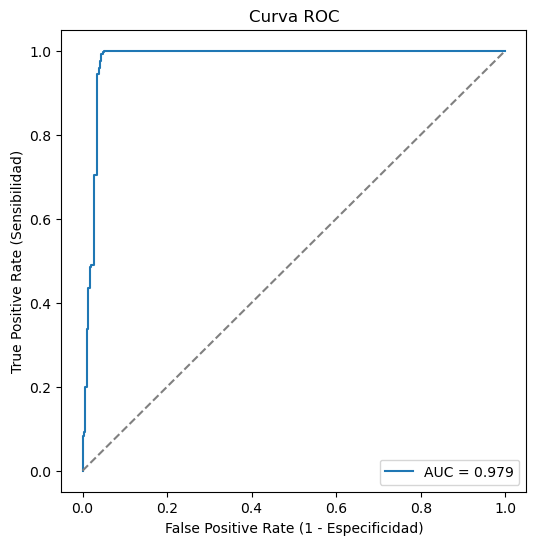

Valor de AUC: 0.9790022514515937


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

print("Valor de AUC:", auc)

### Inciso 6 – Interpretación de coeficientes

Los coeficientes del modelo de regresión logística permiten interpretar la influencia de cada variable sobre la probabilidad de pertenecer a la **clase 1 (alta adicción)**:

- **Coeficientes positivos** → al aumentar la variable, se incrementa la probabilidad de clase 1.  
  Ejemplo: `Time_on_Social_Media`, `Daily_Usage_Hours` y `Time_on_Gaming` muestran los valores más altos, lo que indica que un mayor tiempo en estas actividades aumenta la probabilidad de alta adicción.

- **Coeficientes negativos** → al aumentar la variable, se reduce la probabilidad de clase 1.  
  Ejemplo: `Sleep_Hours`, `Age` y `Self_Esteem` actúan como factores protectores, disminuyendo la probabilidad de alta adicción.

En conjunto, el modelo resalta el papel del **tiempo frente a pantallas** como principal factor de riesgo, mientras que **más horas de sueño, mayor autoestima y mayor edad** tienden a reducir la probabilidad de adicción.

In [10]:
coefs = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": clf.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

coefs["Interpretación"] = np.where(
    coefs["Coeficiente"] > 0,
    "Incrementa la probabilidad de clase 1",
    "Reduce la probabilidad de clase 1"
)

print(coefs)

                     Variable  Coeficiente  \
9        Time_on_Social_Media     1.983620   
1           Daily_Usage_Hours     1.976078   
10             Time_on_Gaming     1.913902   
8             Apps_Used_Daily     0.404941   
14                Gender_Male     0.109719   
6            Parental_Control     0.079195   
4               Anxiety_Level     0.039602   
7        Phone_Checks_Per_Day     0.038878   
15  Phone_Usage_Purpose_Other     0.031429   
13        Weekend_Usage_Hours     0.014075   
3        Academic_Performance     0.001053   
12       Family_Communication     0.000387   
11          Time_on_Education    -0.006793   
5                 Self_Esteem    -0.011833   
0                         Age    -0.039010   
2                 Sleep_Hours    -0.958266   

                           Interpretación  
9   Incrementa la probabilidad de clase 1  
1   Incrementa la probabilidad de clase 1  
10  Incrementa la probabilidad de clase 1  
8   Incrementa la probabilidad de clase 1

### Conclusión final

El análisis realizado permitió construir y evaluar un modelo de **regresión logística** para predecir niveles de adicción en jóvenes a partir de sus hábitos y características asociadas.  

Los resultados muestran que:  
- La **limpieza y preparación de los datos** garantizó un conjunto balanceado y representativo.  
- El modelo alcanzó una **alta exactitud (≈94%)** tanto en validación cruzada como en pruebas con datos no vistos, lo que indica una buena capacidad de generalización.  
- La **curva ROC y el AUC (0.979)** confirmaron un excelente poder discriminativo del modelo.  
- La interpretación de los coeficientes destacó que el **tiempo en redes sociales, uso diario y gaming** son los principales factores de riesgo, mientras que **mayor tiempo de sueño, edad y autoestima** actúan como factores protectores.  
- La variación de **umbrales de decisión** permitió evidenciar cómo cambia el balance entre sensibilidad y especificidad, lo que ofrece flexibilidad según el objetivo del análisis (detectar más casos positivos o reducir falsos positivos).

En conclusión, la regresión logística se consolidó como una herramienta adecuada y efectiva para modelar el fenómeno de la adicción al uso del teléfono, ofreciendo tanto **alto desempeño predictivo** como **interpretación clara de los factores asociados**.